# Import

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, brier_score_loss
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interp
import lightgbm as lgbm

seed = 42
random.seed(seed)
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

import warnings
warnings.filterwarnings("ignore")


# Data


In [2]:
data = pd.read_excel('./data/dataset5.xlsx')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   总体生存时间      393 non-null    float64
 1   feature_2   393 non-null    int64  
 2   feature_3   393 non-null    int64  
 3   feature_4   393 non-null    int64  
 4   feature_5   393 non-null    int64  
 5   feature_9   393 non-null    int64  
 6   feature_10  393 non-null    float64
 7   feature_11  393 non-null    float64
 8   feature_12  393 non-null    float64
 9   feature_13  393 non-null    float64
 10  feature_14  393 non-null    float64
 11  feature_15  393 non-null    int64  
 12  feature_16  393 non-null    float64
 13  feature_17  393 non-null    float64
 14  feature_18  393 non-null    float64
 15  feature_19  393 non-null    float64
 16  feature_20  393 non-null    int64  
 17  feature_21  393 non-null    int64  
 18  feature_22  393 non-null    int64  
 19  feature_23  393 non-null    i

In [3]:
data.head()

,总体生存时间,生存状态（编码）,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,TNM分期（编码汇总）,淋巴清扫
0,6.9079,0,0,1,58,1,1,5.68,51.2,43.1,3.2,42.3,1,19.0,14.9,42.1,11.9,1,2,2,0,3.2,1,0,1,0,1
1,18.5197,0,0,1,48,1,1,12.01,50.4,37.6,2.5,15.0,1,39.0,18.4,40.7,13.0,1,1,2,0,8.0,1,0,0,0,1
2,24.3092,0,0,2,76,0,1,8.99,52.1,37.0,1.7,1.8,0,19.0,14.0,41.9,12.6,1,1,1,0,5.1,1,0,1,0,1
3,9.4408,0,0,1,55,0,1,5.74,55.3,36.8,3.2,3.3,0,18.0,15.3,44.1,11.7,1,2,1,0,8.5,0,1,2,1,0
4,57.1053,1,0,1,51,1,1,9.02,60.3,32.8,3.7,2.1,0,12.0,14.4,41.0,10.9,1,2,2,0,4.7,1,1,1,0,1


In [4]:
data.drop(["生存状态（编码）", "TNM分期（编码汇总）"], axis=1, inplace=True)
data.describe()

,总体生存时间,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,淋巴清扫
count,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000
mean,27.1679,0.2646,1.4707,57.5573,0.2774,0.3893,6.5801,7.6089,2.9878,29.3976,10.5374,0.5827,40.7850,29.9694,40.7513,11.8659,1.1120,2.3486,1.0967,0.3435,5.3715,0.4580,0.1578,1.3690,0.6921
std,21.8705,0.4417,0.4998,9.8197,0.4483,0.5878,2.1395,13.9802,6.0066,133.3235,34.8370,0.4937,49.4194,58.3024,5.3410,1.5293,0.3157,0.5874,0.2959,0.4755,2.8162,0.4989,0.3650,0.5879,0.4622
min,1.5000,0.0000,1.0000,27.0000,0.0000,0.0000,2.2800,1.3200,0.1500,0.6500,0.2000,0.0000,6.0000,3.6000,24.4000,1.1000,1.0000,1.0000,1.0000,0.0000,0.7000,0.0000,0.0000,0.0000,0.0000
25%,10.7333,0.0000,1.0000,50.0000,0.0000,0.0000,5.1100,3.1000,1.2100,2.1700,1.5600,0.0000,17.0000,10.5000,37.6000,10.8000,1.0000,2.0000,1.0000,0.0000,3.0000,0.0000,0.0000,1.0000,0.0000
50%,22.0000,0.0000,1.0000,59.0000,0.0000,0.0000,6.3000,4.0700,1.5800,3.2000,2.8900,1.0000,25.0000,13.4700,41.2000,11.7000,1.0000,2.0000,1.0000,0.0000,5.0000,0.0000,0.0000,1.0000,1.0000
75%,38.0000,1.0000,2.0000,64.0000,1.0000,1.0000,7.6500,5.4600,2.0300,6.4000,5.2400,1.0000,41.0000,19.2000,44.0000,12.7000,1.0000,3.0000,1.0000,1.0000,7.0000,1.0000,0.0000,2.0000,1.0000
max,120.0667,1.0000,2.0000,83.0000,1.0000,2.0000,15.3400,87.2000,43.1000,1404.0000,338.0000,1.0000,370.0000,400.3000,78.3000,18.7000,2.0000,3.0000,2.0000,1.0000,17.0000,1.0000,1.0000,2.0000,1.0000


<AxesSubplot: xlabel='feature_14', ylabel='总体生存时间'>

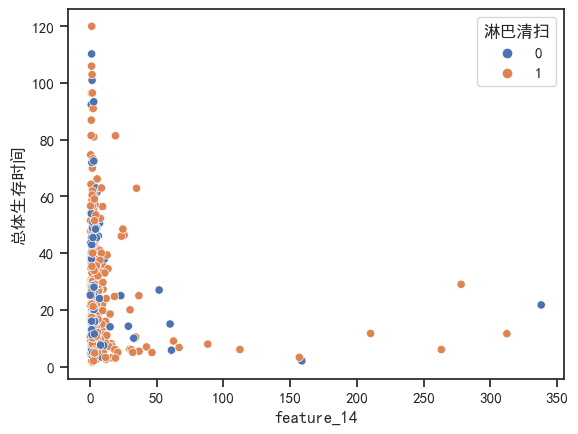

In [9]:
plt.figure()
sns.scatterplot(x=data['feature_14'], y=data['总体生存时间'], hue=data['淋巴清扫'])

# preprocess

## Get class label

In [8]:
def get_class(target):
    if target < 12:
        return 0
    elif target < 24:
        return 1
    elif target < 36:
        return 2
    elif target < 48:
        return 3
    elif target < 60:
        return 4
    else:
        return 5

df = data.copy()
df['总体生存时间'] = df['总体生存时间'].apply(get_class)

Text(0.5, 1.0, 'Number of samples in each class')

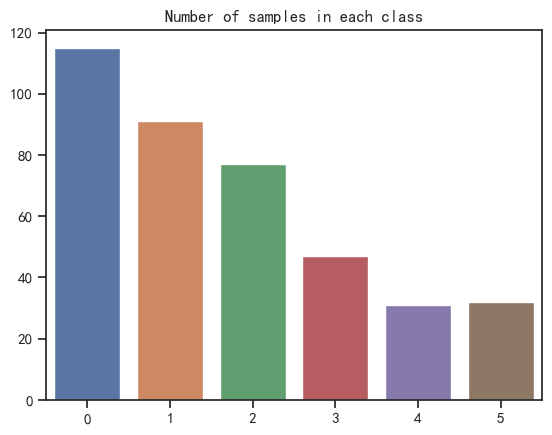

In [9]:
sns.barplot(y=df['总体生存时间'].value_counts().values, x=df['总体生存时间'].value_counts().index)
plt.title('Number of samples in each class')

In [10]:
df.rename(columns={'总体生存时间': 'target'}, inplace=True)

with_ = df[df['淋巴清扫'] == 1]
without_ = df[df['淋巴清扫'] == 0]

# with_ = pd.DataFrame(with_, columns=with_ftr)
# without_ = pd.DataFrame(without_, columns=without_ftr)

with_.drop(['淋巴清扫'], axis=1, inplace=True)
without_.drop(['淋巴清扫'], axis=1, inplace=True)

## Split into training set and test set

In [11]:
# 数据5清扫组seed=1
# 数据5未清扫组seed=2, 13, 47
with_train_x, with_test_x, with_train_y, with_test_y = train_test_split(with_.iloc[:, 1:], with_['target'], test_size=0.1, random_state=1)
without_train_x, without_test_x, without_train_y, without_test_y = train_test_split(without_.iloc[:, 1:], without_['target'], test_size=0.1, random_state=47)

print("LND train size: ", with_train_x.shape)
print("LND test size: ", with_test_x.shape)
print("nLND train size: ", without_train_x.shape)
print("nLND test size: ", without_test_x.shape)

LND train size:  (244, 23)
LND test size:  (28, 23)
nLND train size:  (108, 23)
nLND test size:  (13, 23)


### Save training and testing samples

In [12]:
LND_train = data.iloc[with_train_y.index]
LND_test = data.iloc[with_test_y.index]
nLND_train = data.iloc[without_train_y.index]
nLND_test = data.iloc[without_test_y.index]

# LND_train.to_excel('./Train & Test sets/LND_train.xlsx')
# LND_test.to_excel('./Train & Test sets/LND_test.xlsx')
# nLND_train.to_excel('./Train & Test sets/nLND_train.xlsx')
# nLND_test.to_excel('./Train & Test sets/nLND_test.xlsx')

### Nomalization

In [13]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

def normalize(scaler, x, y):
    x = scaler.fit_transform(x)
    y = np.array(y)
    
    return x, y

In [14]:
with_train_x, with_train_y = normalize(scaler, with_train_x, with_train_y)
with_test_x, with_test_y = normalize(scaler, with_test_x, with_test_y)
without_train_x, without_train_y = normalize(scaler, without_train_x, without_train_y)
without_test_x, without_test_y = normalize(scaler, without_test_x, without_test_y)

print("LND train size: ", with_train_x.shape)
print("LND test size: ", with_test_x.shape)
print("nLND train size: ", without_train_x.shape)
print("nLND test size: ", without_test_x.shape)

LND train size:  (244, 23)
LND test size:  (28, 23)
nLND train size:  (108, 23)
nLND test size:  (13, 23)


In [15]:
# 查看清扫组和未清扫组是否包含所有类别
with_test_y, without_test_y

(array([1, 0, 0, 0, 4, 0, 5, 5, 5, 4, 1, 2, 4, 2, 4, 0, 1, 0, 2, 1, 3, 5,
        1, 0, 1, 3, 1, 4]),
 array([3, 3, 1, 1, 1, 0, 1, 3, 2, 0, 2, 4, 5]))

# Model

In [16]:
def clf_model_eval(name, model, x, y, test_x, test_y, TNM=True):
    K = 16
    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    kf.get_n_splits(x)
    train_acc = []
    train_precision = []
    train_recall = []
    train_f1 = []
    train_auc = []

    # 多折交叉验证
    for train_idx, valid_idx in kf.split(x, y):
        train_x, valid_x = x[train_idx], x[valid_idx]
        train_y, valid_y = y[train_idx], y[valid_idx]
        model.fit(train_x, train_y)
        
        # 对多折验证中的测试数据进行验证，可以不返回
        pred = model.predict(valid_x)
        proba = model.predict_proba(valid_x)
        train_acc.append(accuracy_score(valid_y, pred))
        train_precision.append(precision_score(valid_y, pred, average="macro"))
        train_recall.append(recall_score(valid_y, pred, average="macro"))
        train_f1.append(f1_score(valid_y, pred, average="macro"))
        train_auc.append(roc_auc_score(valid_y, proba, multi_class="ovo", labels=[0, 1, 2, 3, 4, 5], average='macro'))
    
    # pred_proba = model.predict_proba(test_x)
    # return np.mean(acc), np.mean(precision), np.mean(recall), np.mean(f1), np.mean(auc), pred_proba
    # train_res = pd.DataFrame([train_acc, train_precision, train_recall, train_f1, train_auc], index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
    # if TNM:
    #     train_res.to_csv('./CV_result/清扫组/{}_{}折交叉验证结果.csv'.format(name, K))
    # else:
    #     train_res.to_csv('./CV_result/未清扫组/{}_{}折交叉验证结果.csv'.format(name, K))
    
    # model.fit(x, y)
    # 对测试集数据进行验证
    pred = model.predict(test_x)
    proba = model.predict_proba(test_x)

    acc = accuracy_score(test_y, pred)
    precision = precision_score(test_y, pred, average="macro")
    recall = recall_score(test_y, pred, average="macro")
    f1 = f1_score(test_y, pred, average="macro")
    auc = roc_auc_score(test_y, proba, multi_class="ovo", labels=[0, 1, 2, 3, 4, 5], average='macro')
    
    test_res = [acc, precision, recall, f1, auc]
    pred_proba = model.predict_proba(test_x)

    return test_res, pred_proba

In [17]:
clf = {
    "MLP": [
        MLPClassifier(learning_rate="adaptive", max_iter=500),
        MLPClassifier(learning_rate="adaptive", max_iter=500),
    ],
    "SVM": [SVC(probability=True), SVC(probability=True)],
    "RF": [RandomForestClassifier(), RandomForestClassifier()],
    "KNN": [KNeighborsClassifier(), KNeighborsClassifier()],
    "GBDT": [
        lgbm.LGBMClassifier(objective="multiclass"),
        lgbm.LGBMClassifier(objective="multiclass"),
    ],
}

# Results of classification

In [18]:
with_proba = {}
without_proba = {}
with_test_results = {}
without_test_results = {}

for name, models in clf.items():
    test_res, proba = clf_model_eval(
        name,
        models[0],  # 清扫组模型
        with_train_x,
        with_train_y,
        with_test_x,
        with_test_y
    )
    with_test_results[name] = test_res
    with_proba[name] = proba
    
for name, models in clf.items():
    test_res, proba = clf_model_eval(
        name,
        models[1],  # 未清扫组模型
        without_train_x,
        without_train_y,
        without_test_x,
        without_test_y,
        TNM=False
    )
    without_test_results[name] = test_res
    without_proba[name] = proba

In [19]:
df1 = pd.DataFrame(with_test_results, index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
df1 = df1.T
# df1.to_csv('./CV_result/清扫组/测试集结果.csv')
df1

,accuracy,precision,recall,f1,auc
MLP,0.4643,0.5278,0.4060,0.4068,0.7251
SVM,0.3214,0.1776,0.2143,0.1678,0.6586
RF,0.3214,0.2099,0.2238,0.1976,0.7143
KNN,0.2143,0.1139,0.1746,0.1335,0.6767
GBDT,0.2500,0.3125,0.2357,0.2593,0.6547


In [20]:
df2 = pd.DataFrame(without_test_results, index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
df2 = df2.T
# df2.to_csv('./CV_result/未清扫组/测试集结果.csv')
df2

,accuracy,precision,recall,f1,auc
MLP,0.4615,0.3833,0.3472,0.3254,0.7611
SVM,0.3846,0.2870,0.3333,0.2551,0.3500
RF,0.3077,0.2000,0.2361,0.2063,0.7000
KNN,0.3846,0.2778,0.3056,0.2730,0.6986
GBDT,0.4615,0.2063,0.3333,0.2545,0.6819


# Plot

针对多类数据的ROC曲线的可视化方式有两种：

第一种为：采用将原始数据的真实类别标签矩阵和模型预测得到的概率矩阵分别按行展开，转置后形成两列，这就可以近似的看作获得了一个二分类的结果，进而可以可视化ROC曲线。(micro)

第二种方式为：将每一类数据和其他类别的数据看作为一个二分类类的数据模型，然后对数据可视化ROC曲线。为了方便计算每一类样本的ROC曲线的相关取值，可以将类别标签使用label_binarize进行编码。（macro）

In [21]:
def get_roc_data(name, pred_proba, y_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    bs = []
    for i in range(6):
        fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        bs.append(brier_score_loss(y_test[:, i], pred_proba[:, i], pos_label=i))

    
    # micro
    # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(6)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(6):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # 平均AUC
    mean_tpr /= 6
    fpr = all_fpr
    tpr = mean_tpr
    auc_ = auc(fpr, tpr)
    return fpr, tpr, auc_, roc_auc, bs

In [22]:
with_y_test = label_binarize(with_test_y, classes=[0, 1, 2, 3, 4, 5]) 
without_y_test = label_binarize(without_test_y, classes=[0, 1, 2, 3, 4, 5]) 

w_fpr = {}
w_tpr = {}
w_auc = {}
w_cindex = {}
w_bs = {}
wo_cindex = {}
wo_bs = {}
wo_fpr = {}
wo_tpr = {}
wo_auc = {}

for name, pred_proba in with_proba.items():
    w_fpr[name], w_tpr[name], w_auc[name], w_cindex[name], w_bs[name] = get_roc_data(name, pred_proba, with_y_test)

for name, pred_proba in without_proba.items():
    wo_fpr[name], wo_tpr[name], wo_auc[name], wo_cindex[name], wo_bs[name] = get_roc_data(name, pred_proba, without_y_test)

## ROC

In [10]:
def draw_roc(fpr, tpr, roc_auc, switch=True):
    plt.figure()
    lw = 2
    colors = plt.cm.get_cmap("Dark2")
    plt.plot(
        fpr["MLP"],
        tpr["MLP"],
        lw=lw,
        label="MLP (AUC = %0.2f)" % roc_auc["MLP"],
    )
    plt.plot(
        fpr["SVM"],
        tpr["SVM"],
        lw=lw,
        label="SVM (AUC = %0.2f)" % roc_auc["SVM"],
    )
    plt.plot(
        fpr["RF"],
        tpr["RF"],
        lw=lw,
        label="RF (AUC = %0.2f)" % roc_auc["RF"],
    )
    plt.plot(
        fpr["KNN"],
        tpr["KNN"],
        lw=lw,
        label="KNN (AUC = %0.2f)" % roc_auc["KNN"],
    )
    plt.plot(
        fpr["GBDT"],
        tpr["GBDT"],
        lw=lw,
        label="GBDT (AUC = %0.2f)" % roc_auc["GBDT"],
    )
    plt.plot([0, 1], [0, 1], color="#9DA9B4", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    if switch:
        plt.title(f"ROC Curve of Different Models (LND)", fontsize=16)
        # plt.savefig('./imgs/ROC-LND.svg')
    else:
        plt.title("ROC Curve of Different Models (nLND)", fontsize=16)
        # plt.savefig('./imgs/ROC-nLND.svg')
    plt.show()

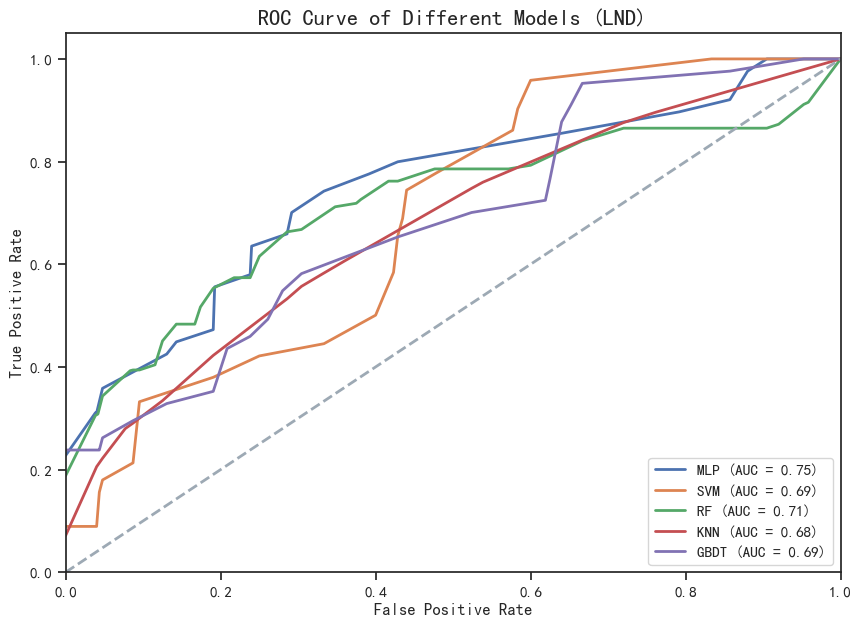

In [24]:
draw_roc(w_fpr, w_tpr, w_auc)   # with

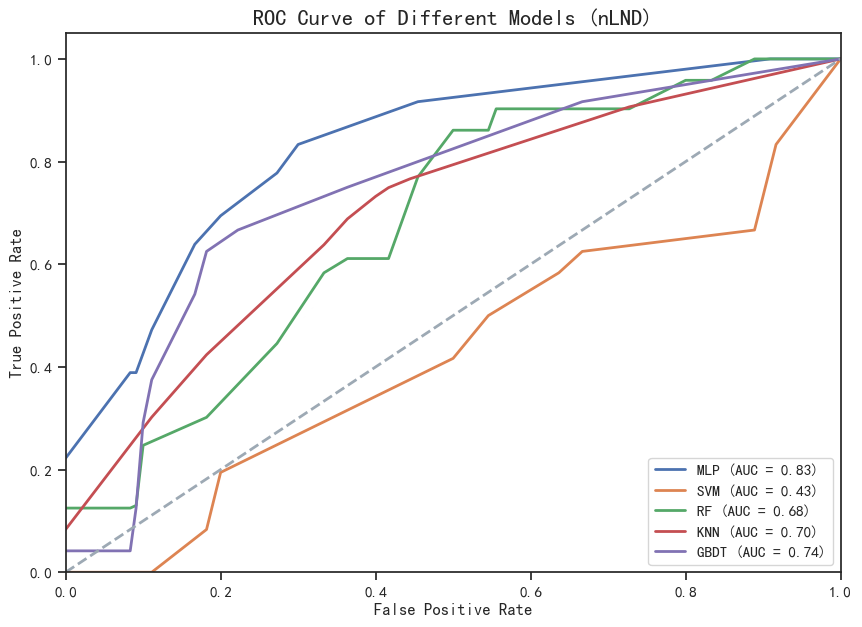

In [25]:
draw_roc(wo_fpr, wo_tpr, wo_auc, switch=False)  # without

## Discrimination and Calibration

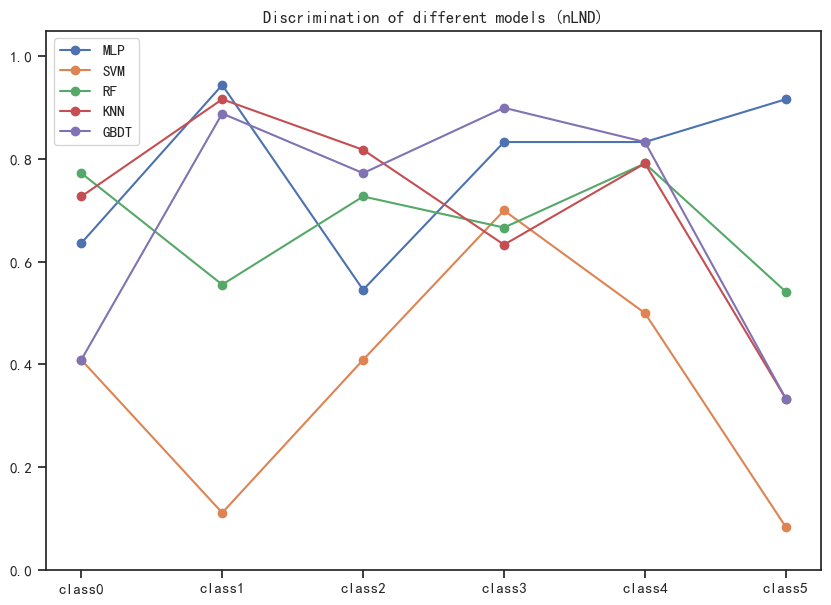

In [26]:
plt.figure(figsize=(10, 7))
# w_cindex
# plt.plot(w_cindex["MLP"].values(), "o-", label="MLP")
# plt.plot(w_cindex["SVM"].values(), "o-", label="SVM")
# plt.plot(w_cindex["RF"].values(), "o-", label="RF")
# plt.plot(w_cindex["KNN"].values(), "o-", label="KNN")
# plt.plot(w_cindex["GBDT"].values(), "o-", label="GBDT")
# plt.title("Discrimination of different models (LND)")
# xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
# plt.xticks(range(0, 6), xlabel)
# plt.ylim([0.0, 1.05])
# plt.legend()
# plt.savefig('./imgs/discrimination-LND.svg')

# wo_cindex
plt.plot(wo_cindex["MLP"].values(), "o-", label="MLP")
plt.plot(wo_cindex["SVM"].values(), "o-", label="SVM")
plt.plot(wo_cindex["RF"].values(), "o-", label="RF")
plt.plot(wo_cindex["KNN"].values(), "o-", label="KNN")
plt.plot(wo_cindex["GBDT"].values(), "o-", label="GBDT")
plt.title("Discrimination of different models (nLND)")
xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
plt.xticks(range(0, 6), xlabel)
plt.ylim([0.0, 1.05])
plt.legend()
# plt.savefig('./imgs/discrimination-nLND.svg')

plt.show()

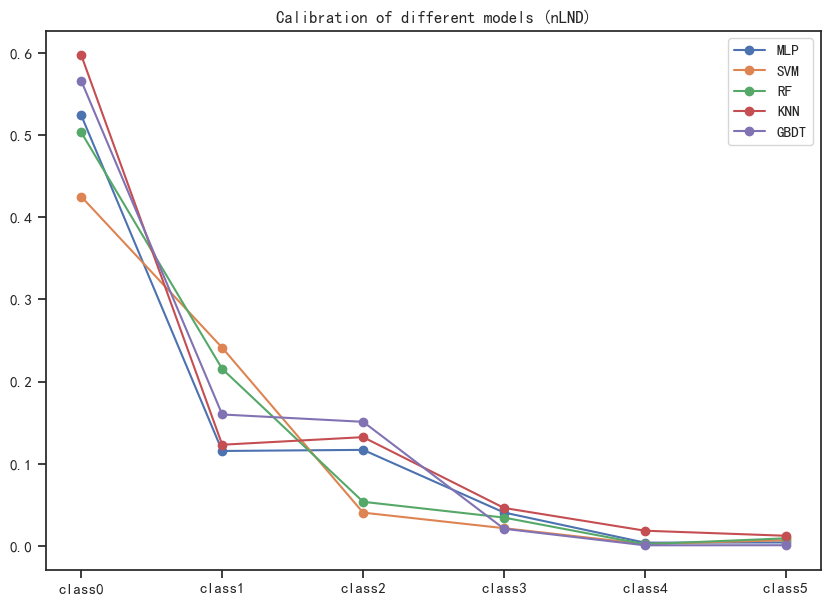

In [27]:
plt.figure(figsize=(10, 7))

# w_bs
# plt.plot(w_bs["MLP"], "o-", label="MLP")
# plt.plot(w_bs["SVM"], "o-", label="SVM")
# plt.plot(w_bs["RF"], "o-", label="RF")
# plt.plot(w_bs["KNN"], "o-", label="KNN")
# plt.plot(w_bs["GBDT"], "o-", label="GBDT")
# plt.title("Calibration of different models (LND)")
# xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
# plt.xticks(range(0, 6), xlabel)
# plt.legend()
# plt.savefig('./imgs/calibration-LND.svg')

# wo_bs
plt.plot(wo_bs["MLP"], "o-", label="MLP")
plt.plot(wo_bs["SVM"], "o-", label="SVM")
plt.plot(wo_bs["RF"], "o-", label="RF")
plt.plot(wo_bs["KNN"], "o-", label="KNN")
plt.plot(wo_bs["GBDT"], "o-", label="GBDT")
plt.title("Calibration of different models (nLND)")
xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
plt.xticks(range(0, 6), xlabel)
plt.legend()
# plt.savefig('./imgs/calibration-nLND.svg')

plt.show()

In [28]:
# ftr_names = with_.columns[1:]
# def print_feature_importances_random_forest(random_forest_model):
    
#     '''
#     Prints the feature importances of a Random Forest model in an ordered way.
#     random_forest_model -> The sklearn.ensemble.RandomForestRegressor or RandomForestClassifier trained model
#     '''
    
#     # Fetch the feature importances and feature names
#     importances = random_forest_model.feature_importances_
#     features = ftr_names
    
#     # Organize them in a dictionary
#     feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    
#     # Sorts the dictionary
#     feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
#     # Prints the feature importances
#     for k, v in feature_importances.items():
#         print(f"{k} -> {v:.4f}")
# # print_feature_importances_random_forest(clf["GBDT"][0])

In [137]:
from sklearn.decomposition import PCA, KernelPCA, NMF
from sklearn.linear_model import LogisticRegressionCV
from mlxtend.plotting import plot_decision_regions


# index = np.random.randint(0, len(with_), 30)
plotx = PCA(n_components=2).fit_transform(with_.iloc[:, 1:])
# plotx = KernelPCA(n_components=2).fit_transform(with_.iloc[:, 1:])
# plotx = NMF(n_components=2).fit_transform(with_.iloc[:, 1:])
ploty = with_.iloc[:, 0].values


plot_clf = LogisticRegressionCV(
    cv=10, max_iter=1000, multi_class="multinomial", solver="lbfgs"
)
# plot_clf = MLPClassifier()
# plot_clf = KNeighborsClassifier()
# plot_clf = RandomForestClassifier()
# plot_clf = SVC()
# plot_clf = lgbm.LGBMClassifier(objective="multiclass")
plot_clf.fit(plotx, ploty)

fig = plt.figure(figsize=(10, 5))
fig = plot_decision_regions(X=plotx, y=ploty, clf=plot_clf)
# plt.xlabel("petal length")
# plt.ylabel("petal width")

# SHAP

使用清扫组数据进行机器学习模型可解释性探索

In [29]:
# import shap
# shap.initjs()
# ftr_names = with_.columns[1:]

# X = with_.iloc[:, 1:]
# explainer = shap.TreeExplainer(clf['GBDT'][0])
# # X = without_.iloc[:, 1:]
# # explainer = shap.TreeExplainer(clf['GBDT'][1])

# shap_values = explainer.shap_values(X)

6类  
244个训练样本  
23项特征

In [30]:
# print(len(shap_values))
# print(shap_values[0].shape)

单样本特征影响图：
- 横轴为SHAP值
- 蓝色代表该特征对预测有负向影响（箭头朝左，SHAP值减少），红色代表该特征对预测有正向影响（箭头朝右，SHAP值增加）

In [31]:
# # 针对分类的第1类，对第一个样本进行解释
# shap.force_plot(explainer.expected_value[0], shap_values[0][0,:] , X.iloc[0,:])

In [32]:
# # 针对分类的第2类，对第一个样本进行解释
# shap.force_plot(explainer.expected_value[1], shap_values[1][:50,:], X.iloc[:50,:])

概括图，该图是对全部样本全部特征的shap值进行求和，可以反映出特征重要性及每个特征对样本类别预测的贡献。
- 对每个特征的SHAP值取绝对值平均，得到特征重要性分布

In [33]:
# shap.summary_plot(shap_values, X, show=False)
# # plt.savefig('./imgs/ftr_importance-LND.svg')
# # plt.savefig('./imgs/ftr_importance-nLND.svg')

## Evidently checking

In [34]:
# from evidently.dashboard import Dashboard
# from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab, ClassificationPerformanceTab

In [35]:
# f_names = with_.columns[1:]
# data.rename(columns={'总体生存时间': 'target'}, inplace=True)
# data4.rename(columns={'总体生存时间': 'target'}, inplace=True)

数据集漂移（Dataset Drift）在单个特征的统计测试结果之上设置了一条规则。默认情况下，如果至少有50%的特征在0.95的置信度下发生漂移，则检测到数据集漂移。

In [36]:
# data_drift = Dashboard(tabs=[DataDriftTab(verbose_level=0), CatTargetDriftTab(verbose_level=0)])
# data_drift.calculate(data, data4, column_mapping=None)
# data_drift.save('./data_drift.html')

模型评价

In [37]:
# train_data = pd.DataFrame(with_train_x, columns=f_names)
# train_data['target'] = with_train_y
# train_data['prediction'] = clf['GBDT'][0].predict(with_train_x)

# test_data = pd.DataFrame(with_test_x, columns=f_names)
# test_data['target'] = with_test_y
# test_data['prediction'] = clf['GBDT'][0].predict(with_test_x)
# # mod_perf

In [38]:
# model_performance = Dashboard(tabs=[ClassificationPerformanceTab(verbose_level=0)])
# model_performance.calculate(train_data, test_data, column_mapping=None)
# model_performance.save('./model_performance.html')